In [13]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
import optuna
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from features
recession_targets = [
    'recession_probability', '1_month_recession_probability',
    '3_month_recession_probability', '6_month_recession_probability'
]

def prepare_exogenous_features(train_df, test_df, target_indicator):
    """Prepare exogenous features for Prophet from train and test dataframes"""
    print(f"\nPreparing exogenous features for {target_indicator}...")
    
    # Define features to exclude (date, target, and recession targets)
    features_to_exclude = ['date'] + recession_targets + [target_indicator]
    
    # Get available features from training data
    available_features = [c for c in train_df.columns if c not in features_to_exclude]
    
    print(f"Available exogenous features: {len(available_features)}")
    print(f"Features: {available_features[:10]}..." if len(available_features) > 10 else f"Features: {available_features}")
    
    # Ensure test data has the same features
    common_features = [f for f in available_features if f in test_df.columns]
    
    if len(common_features) != len(available_features):
        missing_in_test = set(available_features) - set(common_features)
        print(f"Warning: {len(missing_in_test)} features missing in test data: {missing_in_test}")
    
    return common_features

def clean_prophet_data(train_df, test_df, target_indicator, exog_features):
    """Clean and prepare data for Prophet format"""
    print(f"Cleaning Prophet data for {target_indicator}...")
    
    # Create Prophet-format dataframes
    train_prophet = pd.DataFrame({
        'ds': pd.to_datetime(train_df['date']),
        'y': train_df[target_indicator]
    })
    
    test_prophet = pd.DataFrame({
        'ds': pd.to_datetime(test_df['date']),
        'y': test_df[target_indicator]
    })
    
    # Add exogenous features to both train and test
    for feature in exog_features:
        if feature in train_df.columns and feature in test_df.columns:
            # Clean feature data
            train_feature = train_df[feature].replace([np.inf, -np.inf], np.nan)
            test_feature = test_df[feature].replace([np.inf, -np.inf], np.nan)
            
            # Forward fill, backward fill, then use median
            train_feature = train_feature.fillna(method='ffill').fillna(method='bfill')
            test_feature = test_feature.fillna(method='ffill').fillna(method='bfill')
            
            # Use training median for any remaining NaNs
            train_median = train_feature.median()
            train_feature = train_feature.fillna(train_median)
            test_feature = test_feature.fillna(train_median)
            
            # Final fallback to 0
            train_feature = train_feature.fillna(0)
            test_feature = test_feature.fillna(0)
            
            # Add to Prophet dataframes
            train_prophet[feature] = train_feature.values
            test_prophet[feature] = test_feature.values
    
    # Remove rows with NaN target values
    train_prophet = train_prophet.dropna(subset=['y'])
    test_prophet = test_prophet.dropna(subset=['y'])
    
    # Remove features with no variation in training data
    varying_features = []
    for feature in exog_features:
        if feature in train_prophet.columns and train_prophet[feature].nunique() > 1:
            varying_features.append(feature)
        elif feature in train_prophet.columns:
            train_prophet = train_prophet.drop(columns=[feature])
            if feature in test_prophet.columns:
                test_prophet = test_prophet.drop(columns=[feature])
    
    print(f"  Train shape: {train_prophet.shape}, Test shape: {test_prophet.shape}")
    print(f"  Features with variation: {len(varying_features)}")
    print(f"  Remaining missing values - Train: {train_prophet.isnull().sum().sum()}, Test: {test_prophet.isnull().sum().sum()}")
    
    return train_prophet, test_prophet, varying_features

def make_prophet_objective(train_data, test_data, exog_features):
    """Create Optuna objective function for Prophet hyperparameter tuning"""
    def objective(trial):
        # Prophet parameters to tune
        params = {
            'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True),
            'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10, log=True),
            'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10, log=True),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
            'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95),
            'yearly_seasonality': trial.suggest_categorical('yearly_seasonality', [True, False, 'auto']),
            'weekly_seasonality': trial.suggest_categorical('weekly_seasonality', [True, False, 'auto']),
            'daily_seasonality': False,  # Usually False for financial data
        }
        
        try:
            # Create and fit model
            model = Prophet(
                interval_width=0.95,
                **params
            )
            
            # Add exogenous regressors
            for feature in exog_features:
                if feature in train_data.columns:
                    model.add_regressor(feature)
            
            # Fit model
            model.fit(train_data)
            
            # Create future dataframe for validation (use part of training data)
            val_size = min(20, len(test_data))  # Use smaller validation set
            val_data = train_data.tail(val_size).copy()
            
            # Make prediction
            forecast = model.predict(val_data)
            
            # Calculate RMSE
            y_true = val_data['y'].values
            y_pred = forecast['yhat'].values
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            
            return rmse
            
        except Exception as e:
            print(f"Trial failed: {e}")
            return float('inf')
    
    return objective

def forecast_indicator_with_prophet(train_df, test_df, indicator, n_trials=30):
    """Forecast indicator using Prophet with exogenous features"""
    print(f"\n{'='*60}\nFORECASTING: {indicator}\n{'='*60}")
    
    if indicator not in train_df.columns or indicator not in test_df.columns:
        print(f"ERROR: {indicator} not in datasets")
        return None
    
    # Check data availability
    train_series = train_df[indicator].dropna()
    test_series = test_df[indicator].dropna()
    print(f"Series lengths - Train: {len(train_series)}, Test: {len(test_series)}")
    
    if len(train_series) < 20:  # Prophet needs more data points
        print(f"ERROR: Insufficient training data for {indicator} (need at least 20 points)")
        return None
    
    # Prepare exogenous features
    try:
        exog_features = prepare_exogenous_features(train_df, test_df, indicator)
        train_prophet, test_prophet, varying_features = clean_prophet_data(
            train_df, test_df, indicator, exog_features
        )
        
        if len(varying_features) == 0:
            print(f"WARNING: No exogenous features available for {indicator}")
            varying_features = []  # Continue without exogenous features
            
    except Exception as e:
        print(f"ERROR preparing features: {e}")
        return None
    
    if len(train_prophet) < 20:
        print(f"ERROR: Insufficient clean training data for {indicator}: {len(train_prophet)} rows")
        return None
    
    print(f"Clean data shapes - Train: {train_prophet.shape}, Test: {test_prophet.shape}")
    print(f"Using {len(varying_features)} exogenous features: {varying_features[:5]}{'...' if len(varying_features) > 5 else ''}")
    
    # Hyperparameter tuning with Optuna
    print(f"\nRunning Prophet hyperparameter optimization...")
    
    try:
        study = optuna.create_study(direction="minimize")
        study.optimize(
            make_prophet_objective(train_prophet, test_prophet, varying_features),
            n_trials=n_trials,
            show_progress_bar=False
        )
        
        best_params = study.best_params
        print(f"Best parameters: {best_params}")
        print(f"Best validation RMSE: {study.best_value:.4f}")
        
        # Train final model with best parameters
        final_model = Prophet(
            interval_width=0.95,
            **best_params
        )
        
        # Add exogenous regressors
        for feature in varying_features:
            if feature in train_prophet.columns:
                final_model.add_regressor(feature)
        
        # Fit final model
        print("Training final Prophet model...")
        final_model.fit(train_prophet)
        
        # Create future dataframe for forecasting
        future_df = test_prophet[['ds'] + varying_features].copy()
        
        # Make forecast
        forecast = final_model.predict(future_df)
        
        # Extract predictions and actual values
        y_pred = forecast['yhat'].values
        y_true = test_prophet['y'].values
        
        # Calculate metrics
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        # Calculate MAPE
        mask = y_true != 0
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.any() else np.inf
        
        print(f"\nAccuracy Metrics:\n  MAE: {mae:.4f}\n  RMSE: {rmse:.4f}\n  MAPE: {mape:.2f}%")
        
        # Save model
        os.makedirs("prophet_models", exist_ok=True)
        with open(f"prophet_models/{indicator}_prophet_model.pkl", "wb") as f:
            pickle.dump(final_model, f)
        print(f"Model saved to prophet_models/{indicator}_prophet_model.pkl")
        
        return {
            'model': final_model,
            'best_params': best_params,
            'best_val_rmse': study.best_value,
            'forecast': y_pred,
            'actual': y_true,
            'forecast_df': forecast,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'exog_features': varying_features,
            'train_length': len(train_prophet),
            'test_length': len(test_prophet),
            'train_dates': train_prophet['ds'].values,
            'test_dates': test_prophet['ds'].values
        }
        
    except Exception as e:
        print(f"ERROR training Prophet for {indicator}: {e}")
        return None

def plot_prophet_forecast_results(results, indicator):
    """Plot Prophet forecast results"""
    if results is None:
        return
        
    plt.figure(figsize=(15, 8))
    
    # Plot training data (last portion for visibility)
    train_dates = results['train_dates']
    train_plot_size = min(50, len(train_dates))
    train_dates_plot = train_dates[-train_plot_size:]
    
    # We don't have train target values in results, so we'll focus on test data
    test_dates = results['test_dates']
    actual = results['actual']
    forecast = results['forecast']
    forecast_df = results['forecast_df']
    
    # Plot actual vs forecast
    plt.plot(test_dates, actual, label='Actual', color='green', linewidth=2, marker='o', markersize=4)
    plt.plot(test_dates, forecast, label='Forecast', color='red', linewidth=2, marker='s', markersize=4)
    
    # Plot confidence intervals if available
    if 'yhat_lower' in forecast_df.columns and 'yhat_upper' in forecast_df.columns:
        plt.fill_between(test_dates, 
                        forecast_df['yhat_lower'].values, 
                        forecast_df['yhat_upper'].values, 
                        alpha=0.3, color='red', label='Confidence Interval')
    
    # Add title with metrics
    plt.title(f'{indicator} - Prophet Forecast\n'
              f'MAE: {results["mae"]:.4f}, RMSE: {results["rmse"]:.4f}, MAPE: {results["mape"]:.2f}%\n'
              f'Features used: {len(results["exog_features"])}',
              fontsize=14)
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def run_prophet_forecasting_with_exogenous(train_df, test_df, financial_indicators=None, n_trials=30, plot_results=True):
    """Run Prophet forecasting pipeline with exogenous features"""
    print("=" * 80)
    print("PROPHET TIME SERIES FORECASTING - WITH EXOGENOUS FEATURES")
    print("=" * 80)
    
    if financial_indicators is None:
        financial_indicators = [
            '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
            '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
            'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
        ]
    
    train_work = train_df.copy()
    test_work = test_df.copy()
    
    # Check available indicators
    available = [i for i in financial_indicators if i in train_work.columns and i in test_work.columns]
    print(f"Indicators to forecast: {available}")
    print(f"Excluding recession features: {recession_targets}")
    
    all_results = {}
    forecasted = pd.DataFrame({'date': pd.to_datetime(test_work['date'])})
    
    for ind in available:
        res = forecast_indicator_with_prophet(
            train_work, test_work, ind, 
            n_trials=n_trials
        )
        
        if res:
            all_results[ind] = res
            
            # Add results to forecasted dataframe
            forecasted[f'{ind}_forecast'] = np.nan
            forecasted[f'{ind}_actual'] = np.nan
            
            # Align forecasts with dates
            test_dates = pd.to_datetime(res['test_dates'])
            for i, date in enumerate(test_dates):
                mask = forecasted['date'] == date
                if mask.any():
                    idx = forecasted[mask].index[0]
                    if i < len(res['forecast']):
                        forecasted.loc[idx, f'{ind}_forecast'] = res['forecast'][i]
                        forecasted.loc[idx, f'{ind}_actual'] = res['actual'][i]
            
            if plot_results:
                plot_prophet_forecast_results(res, ind)
    
    print(f"\n{'='*60}")
    print("PROPHET FORECASTING COMPLETE")
    print(f"{'='*60}")
    print(f"Successfully forecasted {len(all_results)} indicators")
    
    # Print summary metrics
    if all_results:
        print(f"\nSUMMARY METRICS:")
        for ind, res in all_results.items():
            print(f"{ind:20s} - MAE: {res['mae']:.4f}, RMSE: {res['rmse']:.4f}, MAPE: {res['mape']:.2f}% (Features: {len(res['exog_features'])})")
    
    return all_results, forecasted

def prophet_quick_forecast(train_df, test_df, indicator, exog_features=None):
    """Quick Prophet forecast with default parameters for testing"""
    print(f"\nQuick Prophet forecast for {indicator}...")
    
    # Prepare data
    train_prophet = pd.DataFrame({
        'ds': pd.to_datetime(train_df['date']),
        'y': train_df[indicator]
    }).dropna()
    
    test_prophet = pd.DataFrame({
        'ds': pd.to_datetime(test_df['date']),
        'y': test_df[indicator]
    }).dropna()
    
    # Add exogenous features if specified
    if exog_features:
        for feature in exog_features:
            if feature in train_df.columns and feature in test_df.columns:
                train_prophet[feature] = train_df[feature].fillna(method='ffill').fillna(0)
                test_prophet[feature] = test_df[feature].fillna(method='ffill').fillna(0)
    
    # Create and fit model
    model = Prophet()
    
    # Add regressors
    if exog_features:
        for feature in exog_features:
            if feature in train_prophet.columns:
                model.add_regressor(feature)
    
    model.fit(train_prophet)
    
    # Forecast
    future_df = test_prophet[['ds'] + (exog_features or [])].copy()
    forecast = model.predict(future_df)
    
    # Calculate metrics
    y_true = test_prophet['y'].values
    y_pred = forecast['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f"Quick forecast - MAE: {mae:.4f}, RMSE: {rmse:.4f}")
    
    return model, forecast, y_true, y_pred

In [14]:
train_df = pd.read_csv('../data/fix/feature_selected_recession_train.csv')
test_df = pd.read_csv('../data/fix/feature_selected_recession_test.csv')

[I 2025-09-16 17:47:15,301] A new study created in memory with name: no-name-58f99fb1-4e16-4311-98ae-538d71d1e5e4
17:47:15 - cmdstanpy - INFO - Chain [1] start processing


PROPHET TIME SERIES FORECASTING - WITH EXOGENOUS FEATURES
Indicators to forecast: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index', 'gdp_per_capita']
Excluding recession features: ['recession_probability', '1_month_recession_probability', '3_month_recession_probability', '6_month_recession_probability']

FORECASTING: 1_year_rate
Series lengths - Train: 556, Test: 65

Preparing exogenous features for 1_year_rate...
Available exogenous features: 29
Features: ['3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 1_year_rate...
  Train shape: (556, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (556, 31), Test: (65, 31)
Using 29 exogenous features: ['3_months_rate', '6_months_rate', 'CPI'

17:47:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:47:15,626] Trial 0 finished with value: 0.030856089096199583 and parameters: {'changepoint_prior_scale': 0.23401944851240808, 'seasonality_prior_scale': 0.014826504874974375, 'holidays_prior_scale': 0.5283359082780505, 'seasonality_mode': 'additive', 'changepoint_range': 0.8445359185049739, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.030856089096199583.
17:47:15 - cmdstanpy - INFO - Chain [1] start processing
17:47:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:47:15,980] Trial 1 finished with value: 0.022636607165943453 and parameters: {'changepoint_prior_scale': 0.3044609720689809, 'seasonality_prior_scale': 0.20132435030853196, 'holidays_prior_scale': 2.3006756007501674, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8692068545102783, 'yearly_seasonality': False, 'weekly_seasonality': False}. Best is trial 1 with value: 0.02263660716

Best parameters: {'changepoint_prior_scale': 0.006676474320403762, 'seasonality_prior_scale': 0.10821405609495553, 'holidays_prior_scale': 4.143222959671921, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9463450207952964, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}
Best validation RMSE: 0.0153
Training final Prophet model...

Accuracy Metrics:
  MAE: 0.1500
  RMSE: 0.1739
  MAPE: 20.70%
Model saved to prophet_models/1_year_rate_prophet_model.pkl


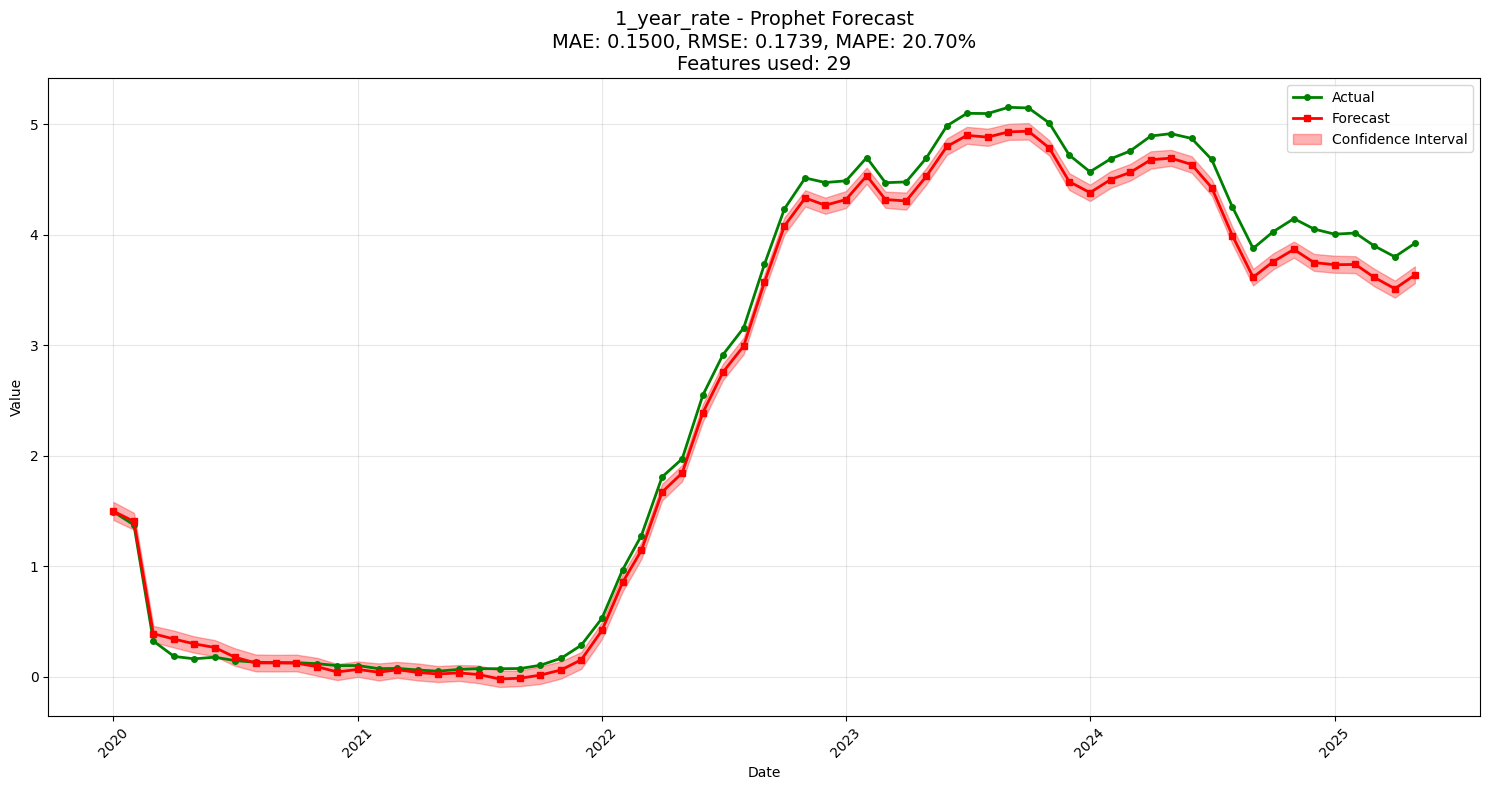

[I 2025-09-16 17:47:22,192] A new study created in memory with name: no-name-04b75b1a-9a8c-441c-8eab-d6d4aadf4400



FORECASTING: 3_months_rate
Series lengths - Train: 635, Test: 65

Preparing exogenous features for 3_months_rate...
Available exogenous features: 29
Features: ['1_year_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 3_months_rate...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate']...

Running Prophet hyperparameter optimization...


17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:47:22,394] Trial 0 finished with value: 0.012100779716871278 and parameters: {'changepoint_prior_scale': 0.007375718396566886, 'seasonality_prior_scale': 0.18916240490432745, 'holidays_prior_scale': 0.1569628150697773, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9314008303790946, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.012100779716871278.
17:47:22 - cmdstanpy - INFO - Chain [1] start processing
17:47:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:47:22,674] Trial 1 finished with value: 0.027626755950353018 and parameters: {'changepoint_prior_scale': 0.26940003465078766, 'seasonality_prior_scale': 0.06527964048410766, 'holidays_prior_scale': 2.5644751000247474, 'seasonality_mode': 'additive', 'changepoint_range': 0.9487511361093874, 'yearly_seasonality': False, 'weekly_seas

Best parameters: {'changepoint_prior_scale': 0.0059091356861098445, 'seasonality_prior_scale': 0.13858655958881583, 'holidays_prior_scale': 8.96630859910927, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8720899487299776, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}
Best validation RMSE: 0.0117
Training final Prophet model...

Accuracy Metrics:
  MAE: 0.2835
  RMSE: 0.3111
  MAPE: 113.34%
Model saved to prophet_models/3_months_rate_prophet_model.pkl


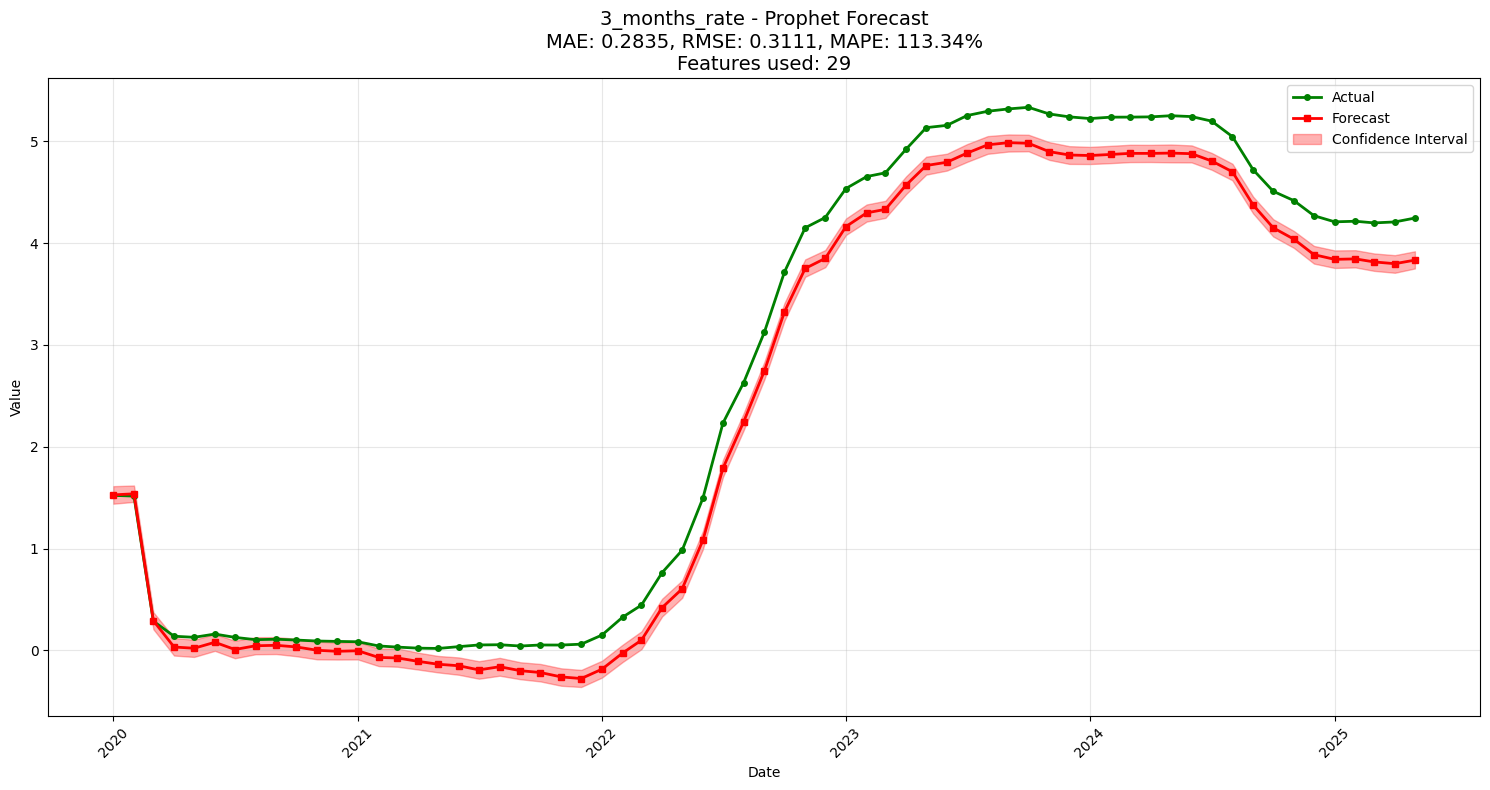

[I 2025-09-16 17:47:29,953] A new study created in memory with name: no-name-1bdc0f49-5b06-420e-9481-d4216f1a531c
17:47:30 - cmdstanpy - INFO - Chain [1] start processing



FORECASTING: 6_months_rate
Series lengths - Train: 635, Test: 65

Preparing exogenous features for 6_months_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 6_months_rate...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', 'CPI', 'INDPRO', '10_year_rate']...

Running Prophet hyperparameter optimization...


17:47:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:47:30,338] Trial 0 finished with value: 0.03015006250202887 and parameters: {'changepoint_prior_scale': 0.41490950963565054, 'seasonality_prior_scale': 1.0300348119655776, 'holidays_prior_scale': 0.14694885681550365, 'seasonality_mode': 'additive', 'changepoint_range': 0.8562172706328657, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.03015006250202887.
17:47:30 - cmdstanpy - INFO - Chain [1] start processing
17:47:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:47:30,769] Trial 1 finished with value: 0.029514585457027134 and parameters: {'changepoint_prior_scale': 0.035365789519989727, 'seasonality_prior_scale': 0.16638629427668383, 'holidays_prior_scale': 2.6329081073925553, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8949484533686587, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 1 with value: 0.029514585457

Best parameters: {'changepoint_prior_scale': 0.005294599225483683, 'seasonality_prior_scale': 5.131455304080117, 'holidays_prior_scale': 0.05617861768774385, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8583476579351946, 'yearly_seasonality': False, 'weekly_seasonality': True}
Best validation RMSE: 0.0104
Training final Prophet model...

Accuracy Metrics:
  MAE: 0.1382
  RMSE: 0.1540
  MAPE: 38.92%
Model saved to prophet_models/6_months_rate_prophet_model.pkl


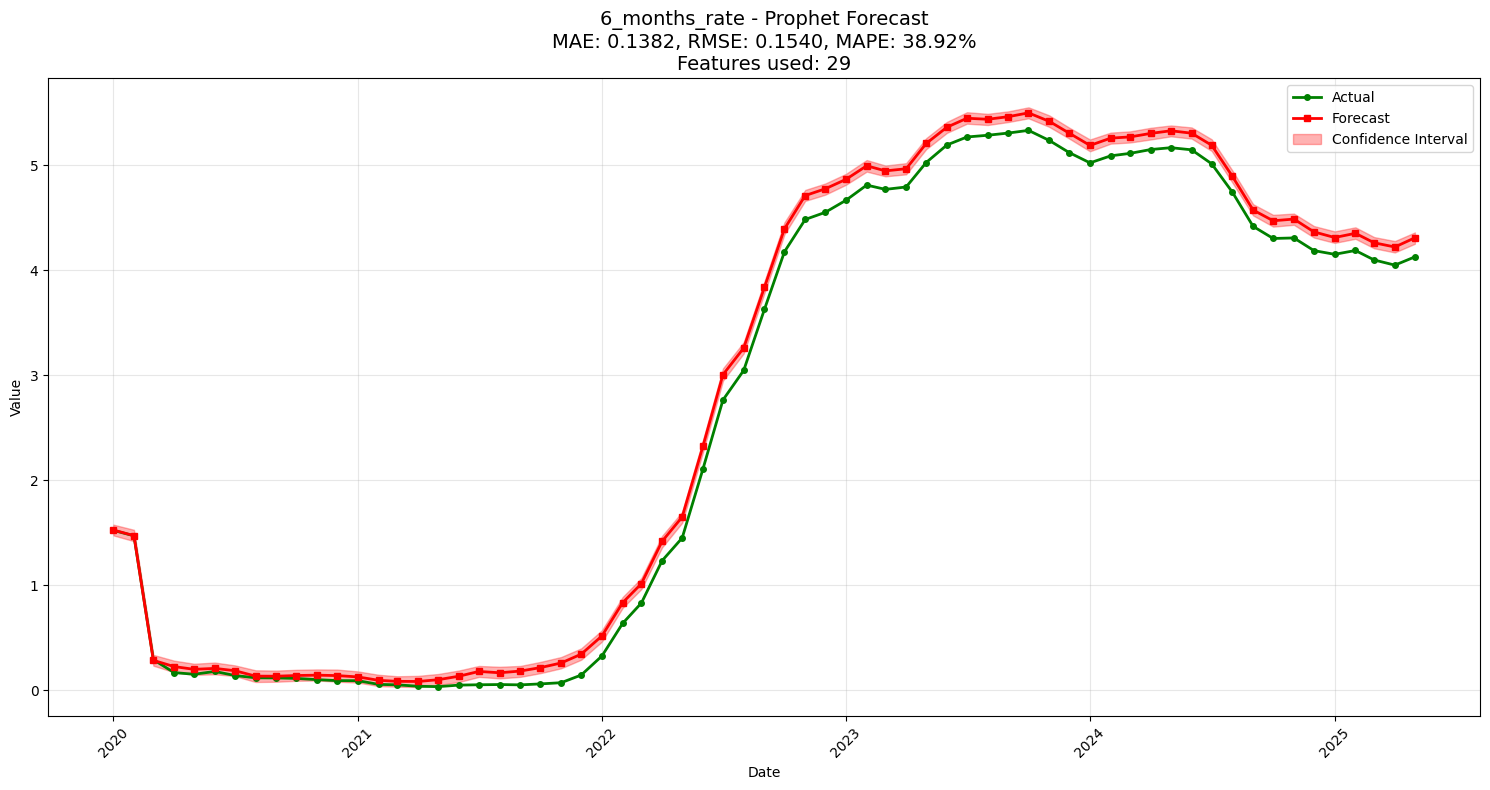

[I 2025-09-16 17:47:39,557] A new study created in memory with name: no-name-46950841-5afc-4973-b596-e6f2ce28c73b
17:47:39 - cmdstanpy - INFO - Chain [1] start processing



FORECASTING: CPI
Series lengths - Train: 635, Test: 65

Preparing exogenous features for CPI...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for CPI...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'INDPRO', '10_year_rate']...

Running Prophet hyperparameter optimization...


17:47:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:47:40,248] Trial 0 finished with value: 0.4070632966403088 and parameters: {'changepoint_prior_scale': 0.3717185592005635, 'seasonality_prior_scale': 2.9176371659842095, 'holidays_prior_scale': 3.6237816617581817, 'seasonality_mode': 'additive', 'changepoint_range': 0.9107016409848598, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 0 with value: 0.4070632966403088.
17:47:40 - cmdstanpy - INFO - Chain [1] start processing
17:47:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:47:40,878] Trial 1 finished with value: 0.38815225103926154 and parameters: {'changepoint_prior_scale': 0.03190927403447512, 'seasonality_prior_scale': 0.12061005841760236, 'holidays_prior_scale': 0.28923660127282125, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8712409431910716, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}. Best is trial 1 with value: 0.3881522510392615

Best parameters: {'changepoint_prior_scale': 0.008838075766413295, 'seasonality_prior_scale': 1.8192555541067372, 'holidays_prior_scale': 2.0576395553165345, 'seasonality_mode': 'additive', 'changepoint_range': 0.9306187691977641, 'yearly_seasonality': False, 'weekly_seasonality': True}
Best validation RMSE: 0.3778
Training final Prophet model...


17:47:54 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 26.7400
  RMSE: 33.1432
  MAPE: 8.74%
Model saved to prophet_models/CPI_prophet_model.pkl


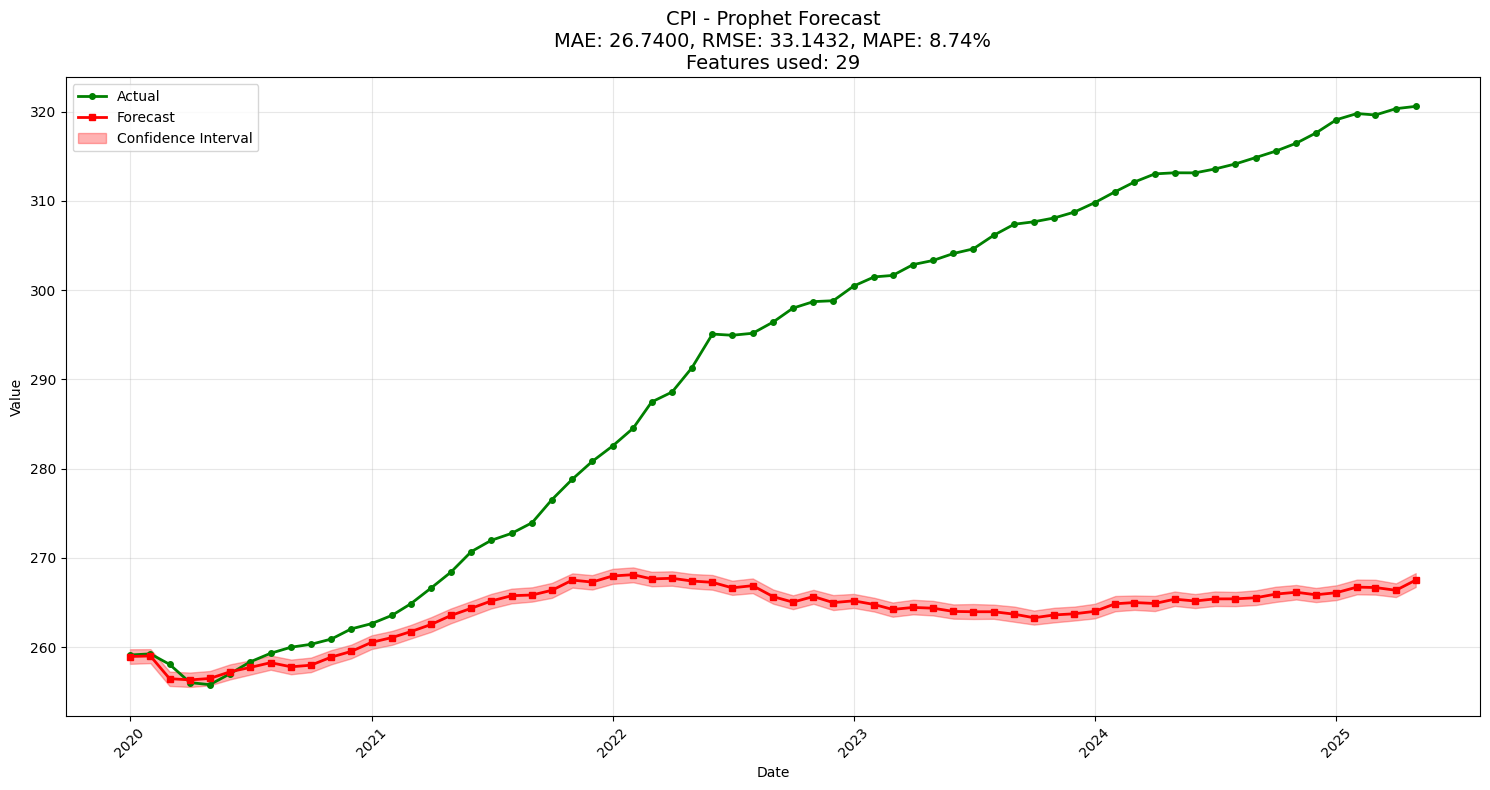

[I 2025-09-16 17:47:55,016] A new study created in memory with name: no-name-bee08198-5078-43c6-bd9b-0b5529e3522c



FORECASTING: INDPRO
Series lengths - Train: 635, Test: 65

Preparing exogenous features for INDPRO...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for INDPRO...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', '10_year_rate']...

Running Prophet hyperparameter optimization...


17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:47:55,513] Trial 0 finished with value: 0.4038705147597709 and parameters: {'changepoint_prior_scale': 0.07994171001374675, 'seasonality_prior_scale': 0.14023856174497992, 'holidays_prior_scale': 2.1382123667411848, 'seasonality_mode': 'additive', 'changepoint_range': 0.8747748786327783, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 0 with value: 0.4038705147597709.
17:47:55 - cmdstanpy - INFO - Chain [1] start processing
17:47:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:47:55,803] Trial 1 finished with value: 0.4119750189356802 and parameters: {'changepoint_prior_scale': 0.01334436867389639, 'seasonality_prior_scale': 8.518467675357998, 'holidays_prior_scale': 0.153584947556236, 'seasonality_mode': 'additive', 'changepoint_range': 0.9380389950171573, 'yearly_seasonality': True, 'weekly_seasonality': True}. Be

Best parameters: {'changepoint_prior_scale': 0.29995905797194317, 'seasonality_prior_scale': 1.4502153870932903, 'holidays_prior_scale': 9.588730260752182, 'seasonality_mode': 'additive', 'changepoint_range': 0.8631222665256109, 'yearly_seasonality': True, 'weekly_seasonality': True}
Best validation RMSE: 0.3852
Training final Prophet model...


17:48:09 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 6.2253
  RMSE: 6.8324
  MAPE: 6.10%
Model saved to prophet_models/INDPRO_prophet_model.pkl


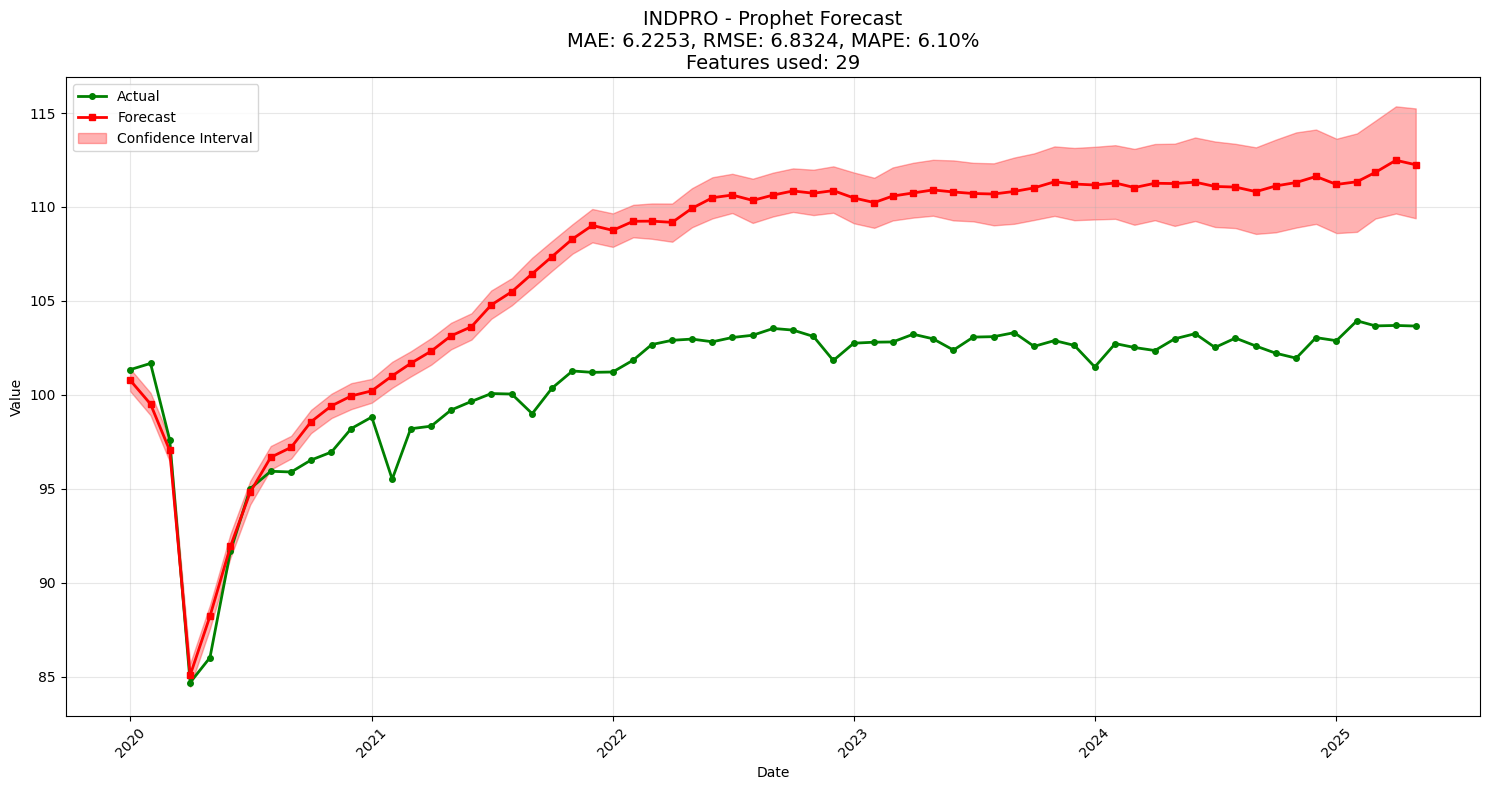


FORECASTING: 10_year_rate
Series lengths - Train: 635, Test: 65

Preparing exogenous features for 10_year_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for 10_year_rate...


[I 2025-09-16 17:48:10,181] A new study created in memory with name: no-name-ae584b3c-f059-4c89-bec3-a4ce58481344
17:48:10 - cmdstanpy - INFO - Chain [1] start processing


  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


17:48:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:48:10,473] Trial 0 finished with value: 0.08349295845369219 and parameters: {'changepoint_prior_scale': 0.39309219575489524, 'seasonality_prior_scale': 0.05732567740665505, 'holidays_prior_scale': 0.266564768051499, 'seasonality_mode': 'additive', 'changepoint_range': 0.8756901363368588, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.08349295845369219.
17:48:10 - cmdstanpy - INFO - Chain [1] start processing
17:48:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:48:10,688] Trial 1 finished with value: 0.10192392736891395 and parameters: {'changepoint_prior_scale': 0.17003816938731658, 'seasonality_prior_scale': 0.5773251419925554, 'holidays_prior_scale': 0.06437413851846632, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9025342083728173, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.08349295845369

Best parameters: {'changepoint_prior_scale': 0.025827376886654894, 'seasonality_prior_scale': 0.0401481759252145, 'holidays_prior_scale': 0.4723701286530301, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8541784893037191, 'yearly_seasonality': False, 'weekly_seasonality': True}
Best validation RMSE: 0.0719
Training final Prophet model...

Accuracy Metrics:
  MAE: 0.2198
  RMSE: 0.2484
  MAPE: 8.34%
Model saved to prophet_models/10_year_rate_prophet_model.pkl


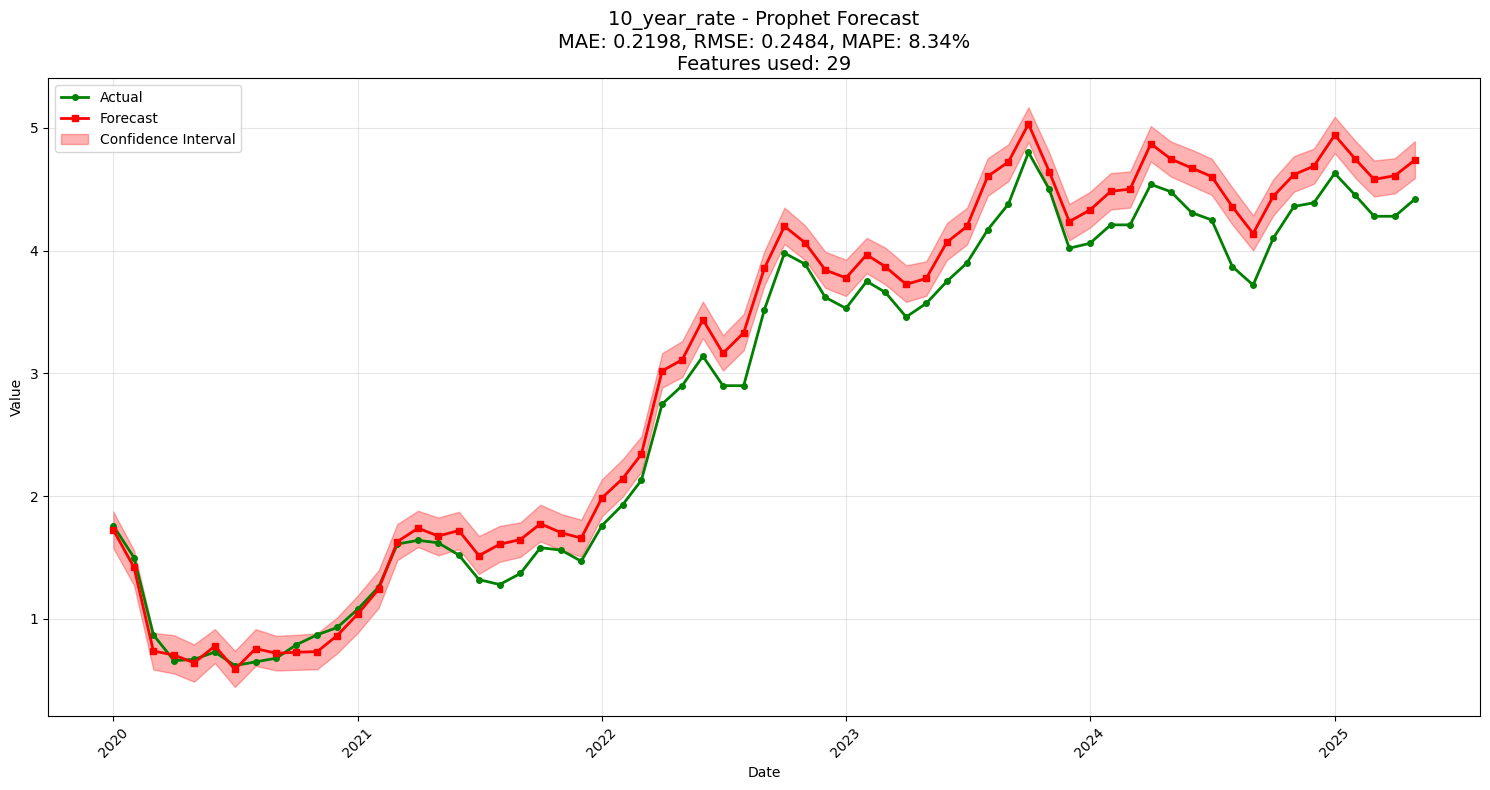

[I 2025-09-16 17:48:16,955] A new study created in memory with name: no-name-58703cad-cd88-418a-b6e5-c9d1761d2abd
17:48:17 - cmdstanpy - INFO - Chain [1] start processing



FORECASTING: share_price
Series lengths - Train: 635, Test: 65

Preparing exogenous features for share_price...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'unemployment_rate', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for share_price...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


17:48:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:48:17,306] Trial 0 finished with value: 2.82583133586141 and parameters: {'changepoint_prior_scale': 0.07990079484350024, 'seasonality_prior_scale': 0.5346585750214358, 'holidays_prior_scale': 0.017309477795581275, 'seasonality_mode': 'additive', 'changepoint_range': 0.9313531941121811, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 2.82583133586141.
17:48:17 - cmdstanpy - INFO - Chain [1] start processing
17:48:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:48:17,569] Trial 1 finished with value: 2.739440642637553 and parameters: {'changepoint_prior_scale': 0.012729546393768196, 'seasonality_prior_scale': 0.013765014829093355, 'holidays_prior_scale': 0.7969828546549298, 'seasonality_mode': 'additive', 'changepoint_range': 0.8496227564752685, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 1 with value: 2.739440642637553.
17:48:17 

Best parameters: {'changepoint_prior_scale': 0.2547049750182412, 'seasonality_prior_scale': 5.59118555120725, 'holidays_prior_scale': 8.378398510396439, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9401233446570169, 'yearly_seasonality': True, 'weekly_seasonality': True}
Best validation RMSE: 2.3028
Training final Prophet model...


17:48:29 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 11.9488
  RMSE: 14.3331
  MAPE: 8.23%
Model saved to prophet_models/share_price_prophet_model.pkl


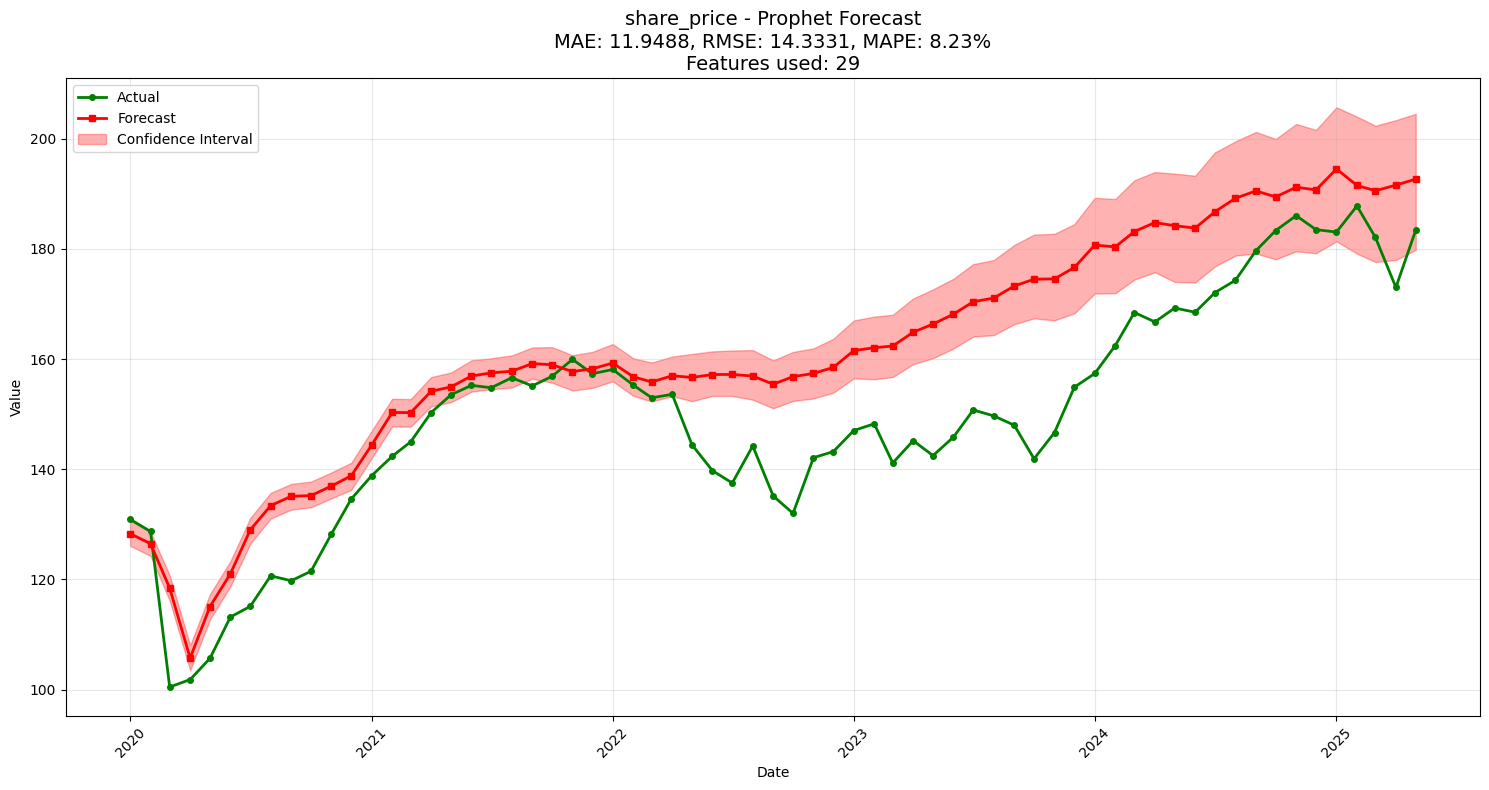


FORECASTING: unemployment_rate
Series lengths - Train: 635, Test: 65

Preparing exogenous features for unemployment_rate...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'PPI', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for unemployment_rate...


[I 2025-09-16 17:48:29,678] A new study created in memory with name: no-name-44056190-7499-46d5-9a59-97e076167912


  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


17:48:29 - cmdstanpy - INFO - Chain [1] start processing
17:48:29 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:48:29,839] Trial 0 finished with value: 0.10587911495216416 and parameters: {'changepoint_prior_scale': 0.021855278339278975, 'seasonality_prior_scale': 1.2902019143740953, 'holidays_prior_scale': 2.401459593765733, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8520151398754185, 'yearly_seasonality': True, 'weekly_seasonality': False}. Best is trial 0 with value: 0.10587911495216416.
17:48:29 - cmdstanpy - INFO - Chain [1] start processing
17:48:30 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:48:30,073] Trial 1 finished with value: 0.104144385564293 and parameters: {'changepoint_prior_scale': 0.08902940234027687, 'seasonality_prior_scale': 0.3118070811601619, 'holidays_prior_scale': 2.6859388462138676, 'seasonality_mode': 'additive', 'changepoint_range': 0.9067449612455379, 'yearly_seasonality': False, 'weekly_seasonality': 

Best parameters: {'changepoint_prior_scale': 0.011014668810795578, 'seasonality_prior_scale': 5.247048994681918, 'holidays_prior_scale': 0.01058062988934008, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.849079748625461, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}
Best validation RMSE: 0.0896
Training final Prophet model...

Accuracy Metrics:
  MAE: 2.1456
  RMSE: 2.6922
  MAPE: 41.02%
Model saved to prophet_models/unemployment_rate_prophet_model.pkl


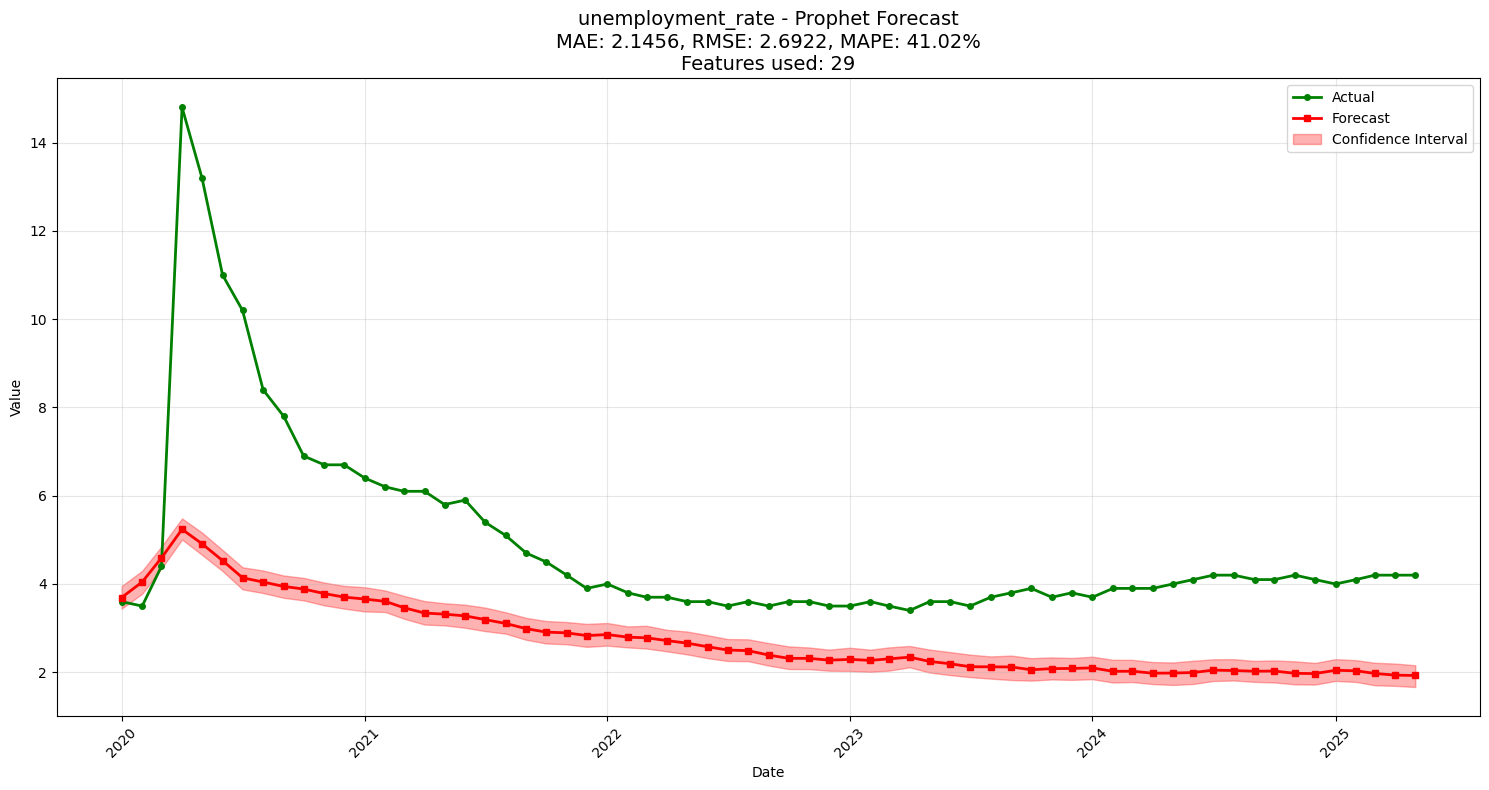

[I 2025-09-16 17:48:38,612] A new study created in memory with name: no-name-cc8c7e2e-b7d6-4fbc-bab6-634621d61406
17:48:38 - cmdstanpy - INFO - Chain [1] start processing



FORECASTING: PPI
Series lengths - Train: 635, Test: 65

Preparing exogenous features for PPI...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'OECD_CLI_index', 'CSI_index']...
Cleaning Prophet data for PPI...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


17:48:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:48:39,206] Trial 0 finished with value: 4.716558673770278 and parameters: {'changepoint_prior_scale': 0.4833294094612782, 'seasonality_prior_scale': 0.03120430435082712, 'holidays_prior_scale': 0.06377355675466496, 'seasonality_mode': 'additive', 'changepoint_range': 0.8763118729113808, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 0 with value: 4.716558673770278.
17:48:39 - cmdstanpy - INFO - Chain [1] start processing
17:48:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:48:39,409] Trial 1 finished with value: 4.668708691866664 and parameters: {'changepoint_prior_scale': 0.01454209520633452, 'seasonality_prior_scale': 0.09783297135271374, 'holidays_prior_scale': 4.152941604798594, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8608657759316429, 'yearly_seasonality': 'auto', 'weekly_seasonality': False}. Best is trial 1 with value: 4.668708691866664.
17:

Best parameters: {'changepoint_prior_scale': 0.4763914662107695, 'seasonality_prior_scale': 0.07270780740237996, 'holidays_prior_scale': 0.12832919561661615, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8213919106154776, 'yearly_seasonality': 'auto', 'weekly_seasonality': False}
Best validation RMSE: 3.5100
Training final Prophet model...


17:48:49 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 145.4574
  RMSE: 162.7656
  MAPE: 29.07%
Model saved to prophet_models/PPI_prophet_model.pkl


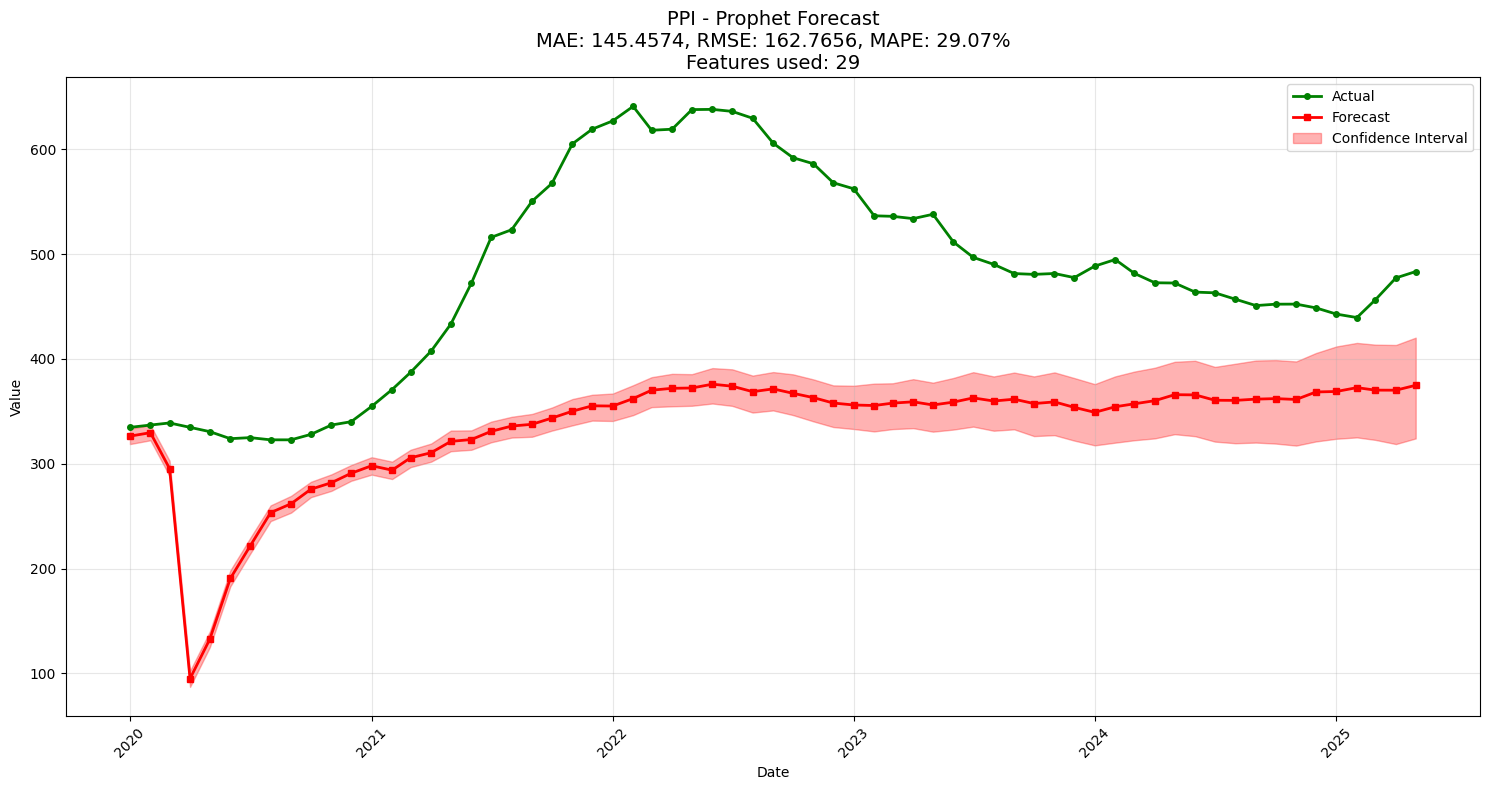


FORECASTING: OECD_CLI_index
Series lengths - Train: 635, Test: 65

Preparing exogenous features for OECD_CLI_index...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'CSI_index']...
Cleaning Prophet data for OECD_CLI_index...


[I 2025-09-16 17:48:49,883] A new study created in memory with name: no-name-75ce76e5-b99a-468a-a663-011210ec8dd9
17:48:49 - cmdstanpy - INFO - Chain [1] start processing


  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


17:48:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:48:50,294] Trial 0 finished with value: 0.045754148947640925 and parameters: {'changepoint_prior_scale': 0.08535973824849707, 'seasonality_prior_scale': 0.2830108647875428, 'holidays_prior_scale': 0.0547218625321892, 'seasonality_mode': 'additive', 'changepoint_range': 0.8006571036335399, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 0.045754148947640925.
17:48:50 - cmdstanpy - INFO - Chain [1] start processing
17:48:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:48:50,654] Trial 1 finished with value: 0.05827095582140188 and parameters: {'changepoint_prior_scale': 0.002425562914752099, 'seasonality_prior_scale': 0.37437313531912964, 'holidays_prior_scale': 0.05156367661501823, 'seasonality_mode': 'additive', 'changepoint_range': 0.8951906961932024, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}. Best is trial 0 with value: 0.0457541489476409

Best parameters: {'changepoint_prior_scale': 0.0015840583852401932, 'seasonality_prior_scale': 0.010426137711412249, 'holidays_prior_scale': 4.130926392158026, 'seasonality_mode': 'additive', 'changepoint_range': 0.806475730178326, 'yearly_seasonality': False, 'weekly_seasonality': 'auto'}
Best validation RMSE: 0.0401
Training final Prophet model...

Accuracy Metrics:
  MAE: 0.2958
  RMSE: 0.3481
  MAPE: 0.30%
Model saved to prophet_models/OECD_CLI_index_prophet_model.pkl


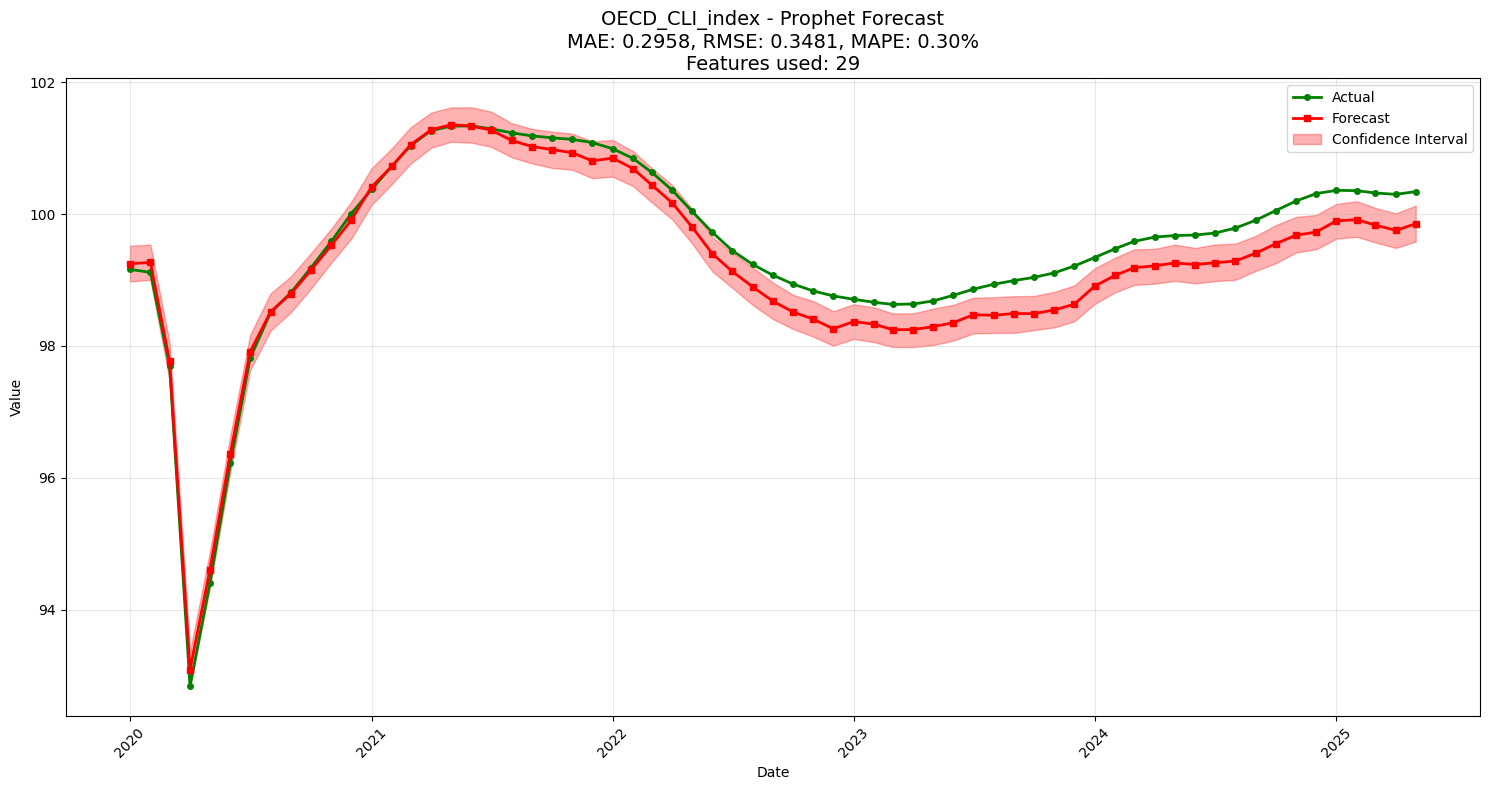

[I 2025-09-16 17:49:00,530] A new study created in memory with name: no-name-42a79321-ea21-430e-99b0-323365c46d1e
17:49:00 - cmdstanpy - INFO - Chain [1] start processing



FORECASTING: CSI_index
Series lengths - Train: 635, Test: 65

Preparing exogenous features for CSI_index...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning Prophet data for CSI_index...
  Train shape: (635, 31), Test shape: (65, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (65, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


17:49:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:49:00,748] Trial 0 finished with value: 2.5665778194719295 and parameters: {'changepoint_prior_scale': 0.08118547640750758, 'seasonality_prior_scale': 0.3020946107468701, 'holidays_prior_scale': 0.10962143542270096, 'seasonality_mode': 'additive', 'changepoint_range': 0.919993211461519, 'yearly_seasonality': True, 'weekly_seasonality': 'auto'}. Best is trial 0 with value: 2.5665778194719295.
17:49:00 - cmdstanpy - INFO - Chain [1] start processing
17:49:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:49:00,869] Trial 1 finished with value: 2.456397004701725 and parameters: {'changepoint_prior_scale': 0.006332570134101421, 'seasonality_prior_scale': 0.020497048663071525, 'holidays_prior_scale': 0.18685271015667226, 'seasonality_mode': 'additive', 'changepoint_range': 0.8952555020262557, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto'}. Best is trial 1 with value: 2.456397004701725.
17:

Best parameters: {'changepoint_prior_scale': 0.013806471478203282, 'seasonality_prior_scale': 0.08156088370492362, 'holidays_prior_scale': 0.36449207610223683, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.9380700068696322, 'yearly_seasonality': False, 'weekly_seasonality': False}
Best validation RMSE: 2.2253
Training final Prophet model...

Accuracy Metrics:
  MAE: 11.0421
  RMSE: 13.4331
  MAPE: 16.24%
Model saved to prophet_models/CSI_index_prophet_model.pkl


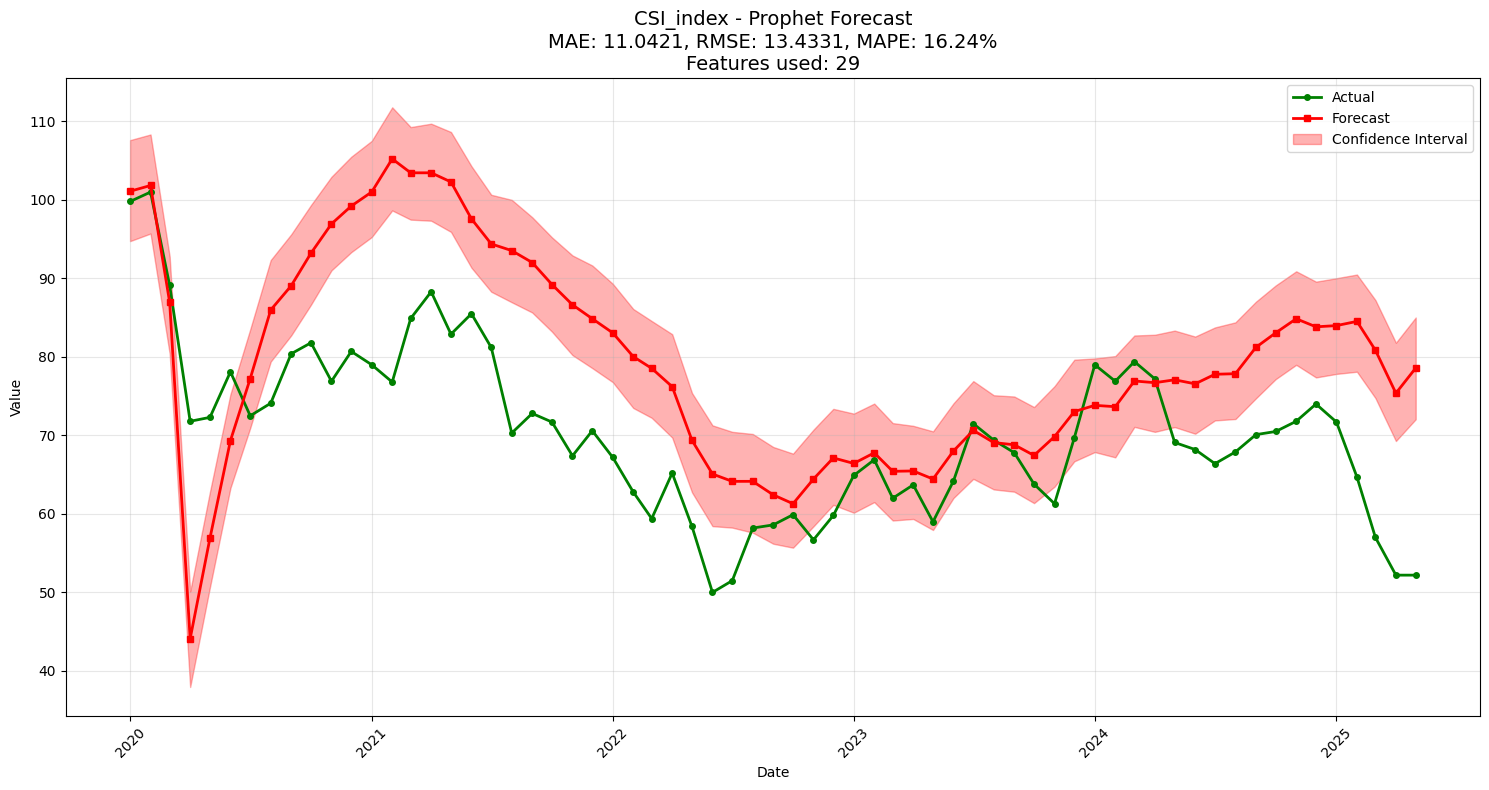

[I 2025-09-16 17:49:04,970] A new study created in memory with name: no-name-0acb6762-1cb1-4e89-a459-86f79ad5ba66
17:49:05 - cmdstanpy - INFO - Chain [1] start processing



FORECASTING: gdp_per_capita
Series lengths - Train: 635, Test: 64

Preparing exogenous features for gdp_per_capita...
Available exogenous features: 29
Features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 'OECD_CLI_index']...
Cleaning Prophet data for gdp_per_capita...
  Train shape: (635, 31), Test shape: (64, 31)
  Features with variation: 29
  Remaining missing values - Train: 0, Test: 0
Clean data shapes - Train: (635, 31), Test: (64, 31)
Using 29 exogenous features: ['1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO']...

Running Prophet hyperparameter optimization...


17:49:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:49:05,735] Trial 0 finished with value: 70.2821350132195 and parameters: {'changepoint_prior_scale': 0.007700843916424701, 'seasonality_prior_scale': 0.06789593161515368, 'holidays_prior_scale': 0.22400183374367533, 'seasonality_mode': 'multiplicative', 'changepoint_range': 0.8304456292992454, 'yearly_seasonality': True, 'weekly_seasonality': True}. Best is trial 0 with value: 70.2821350132195.
17:49:05 - cmdstanpy - INFO - Chain [1] start processing
17:49:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-09-16 17:49:06,416] Trial 1 finished with value: 70.06989475066769 and parameters: {'changepoint_prior_scale': 0.2853331881383014, 'seasonality_prior_scale': 0.010913270885741233, 'holidays_prior_scale': 0.02118384088415224, 'seasonality_mode': 'additive', 'changepoint_range': 0.9485612905551819, 'yearly_seasonality': 'auto', 'weekly_seasonality': False}. Best is trial 1 with value: 70.06989475066769.
17:

Best parameters: {'changepoint_prior_scale': 0.024087989188240885, 'seasonality_prior_scale': 0.15752013983304394, 'holidays_prior_scale': 0.01117852560648137, 'seasonality_mode': 'additive', 'changepoint_range': 0.8832544414164095, 'yearly_seasonality': 'auto', 'weekly_seasonality': True}
Best validation RMSE: 68.9848
Training final Prophet model...


17:49:25 - cmdstanpy - INFO - Chain [1] done processing



Accuracy Metrics:
  MAE: 149.6895
  RMSE: 175.0175
  MAPE: 0.22%
Model saved to prophet_models/gdp_per_capita_prophet_model.pkl


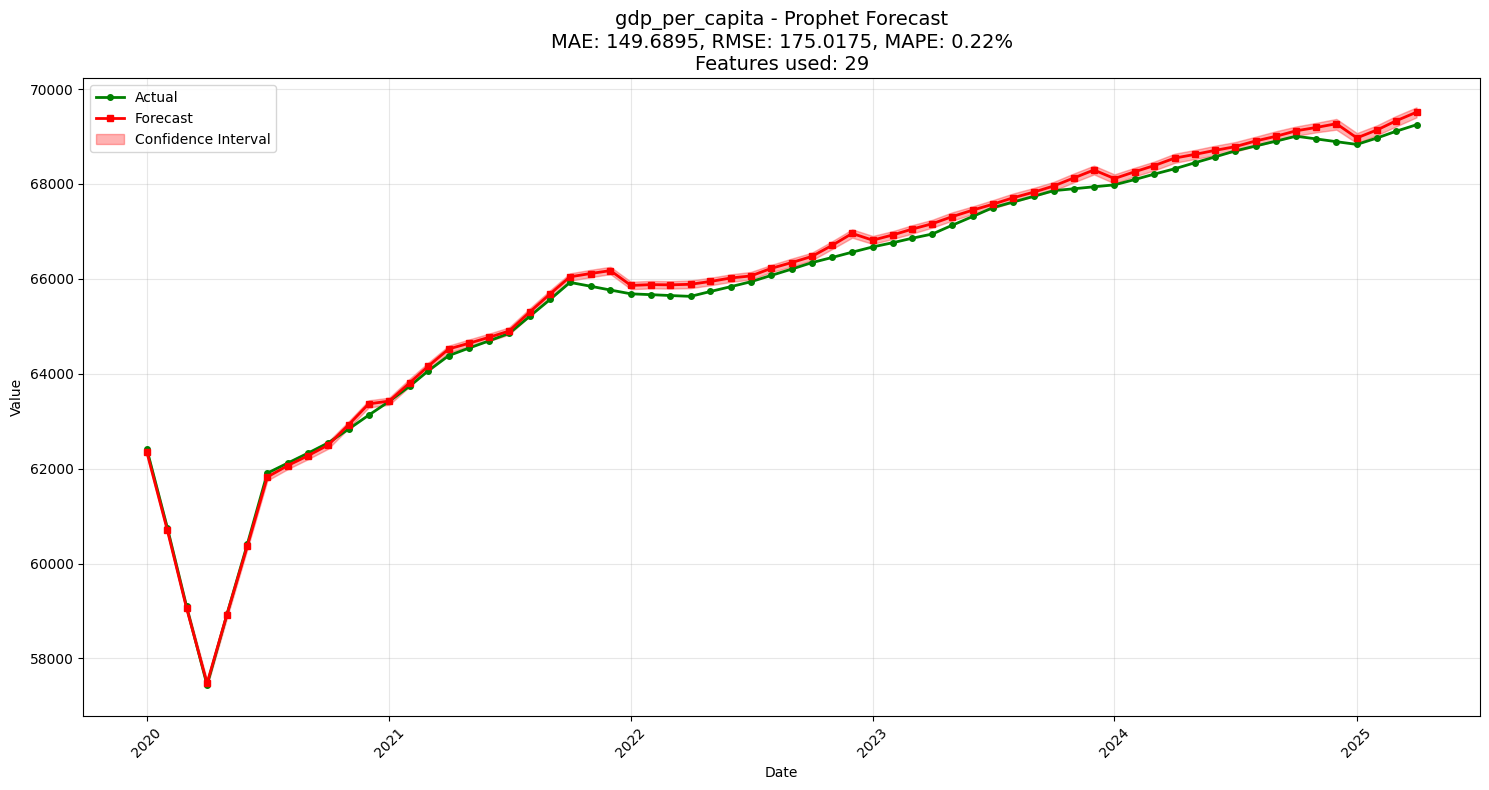


PROPHET FORECASTING COMPLETE
Successfully forecasted 12 indicators

SUMMARY METRICS:
1_year_rate          - MAE: 0.1500, RMSE: 0.1739, MAPE: 20.70% (Features: 29)
3_months_rate        - MAE: 0.2835, RMSE: 0.3111, MAPE: 113.34% (Features: 29)
6_months_rate        - MAE: 0.1382, RMSE: 0.1540, MAPE: 38.92% (Features: 29)
CPI                  - MAE: 26.7400, RMSE: 33.1432, MAPE: 8.74% (Features: 29)
INDPRO               - MAE: 6.2253, RMSE: 6.8324, MAPE: 6.10% (Features: 29)
10_year_rate         - MAE: 0.2198, RMSE: 0.2484, MAPE: 8.34% (Features: 29)
share_price          - MAE: 11.9488, RMSE: 14.3331, MAPE: 8.23% (Features: 29)
unemployment_rate    - MAE: 2.1456, RMSE: 2.6922, MAPE: 41.02% (Features: 29)
PPI                  - MAE: 145.4574, RMSE: 162.7656, MAPE: 29.07% (Features: 29)
OECD_CLI_index       - MAE: 0.2958, RMSE: 0.3481, MAPE: 0.30% (Features: 29)
CSI_index            - MAE: 11.0421, RMSE: 13.4331, MAPE: 16.24% (Features: 29)
gdp_per_capita       - MAE: 149.6895, RMSE: 175.01

In [15]:
# Main forecasting function (same interface as XGBoost)
all_results, forecasted = run_prophet_forecasting_with_exogenous(
    train_df, test_df, 
    financial_indicators=financial_indicators,
    n_trials=30,  # Prophet is slower, so fewer trials
    plot_results=True
)

# # Quick test without hyperparameter optimization
# model, forecast, actual, predicted = prophet_quick_forecast(
#     train_df, test_df, '1_year_rate', 
#     exog_features=['3_months_rate', 'CPI', 'unemployment_rate']
# )